In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
np.random.seed(1)
N=1000
Wafer1 = np.random.normal(loc = 0.0, scale = 1.0, size = N)
Wafer2 = np.random.normal(loc = 2.0, scale = 1.0, size = N)
print(np.shape(Wafer1))

(1000,)


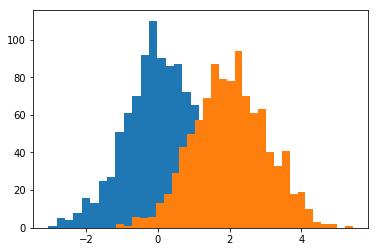

In [3]:
import matplotlib.pyplot as plt
plt.hist(Wafer1,bins=30)
plt.hist(Wafer2, bins=30)
plt.show()

In [7]:
from scipy.stats import gaussian_kde

pdf1 = gaussian_kde(Wafer1)
pdf2 = gaussian_kde(Wafer2)

X1 = np.linspace(min(Wafer1), max(Wafer1), num=N)
X2 = np.linspace(min(Wafer2), max(Wafer2), num=N)
y1 = pdf1(X1)
y2 = pdf2(X2)

print(np.shape(X1), np.shape(y1), type(X1), type(y1))

(1000,) (1000,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [50]:
from scipy.fftpack import fft,ifft

# X1
yy1 = fft(y1)
yyf1 = abs(yy1) # amplitude
# yyf1 = yyf1 / (N/2)
yp_1 = np.angle(yy1) # phase

xx1 = X1
xxf1 = X1

print(type(yy1[0]))
print(np.shape(yy1), np.shape(yyf1), np.shape(xx1), np.shape(xxf1))

# X2
yy2 = fft(y2)
yyf2 = abs(yy2) # amplitude
# yyf2 = yyf2 / (N/2)
yp_2 = np.angle(yy2) # phase

xx2 = X2
xxf2 = X2

<class 'numpy.complex128'>
(1000,) (1000,) (1000,) (1000,)


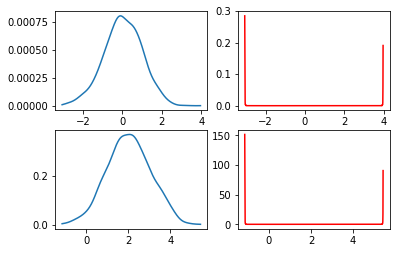

In [52]:
plt.subplot(221)
plt.plot(X1, y1)

plt.subplot(222)
plt.plot(xx1, yyf1, 'r')

plt.subplot(223)
plt.plot(X2, y2)

plt.subplot(224)
plt.plot(xx2, yyf2, 'r')

plt.show()

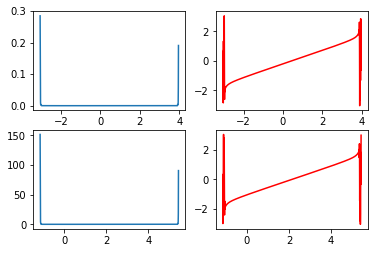

In [53]:
plt.subplot(221)
plt.plot(xx1, yyf1)

plt.subplot(222)
plt.plot(xx1, yp_1, 'r')

plt.subplot(223)
plt.plot(xx2, yyf2)

plt.subplot(224)
plt.plot(xx2, yp_2, 'r')

plt.show()

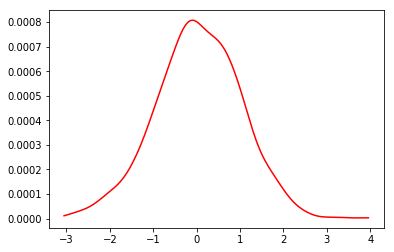

In [67]:
def reconstruct_data(mag, phase):
    y_real = mag * np.cos(phase)
    y_imag = mag * np.sin(phase)
    number = len(y_real)
    y = np.array([np.complex(y_real[i], y_imag[i]) for i in range(number)])
    return ifft(y)

y_test = reconstruct_data(yyf1, yp_1)

plt.plot(X1, y_test, 'r')
plt.show()

In [68]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

def plot_data(X, y, predicted):
    plt.scatter(X, y, marker='x')
    plt.plot(X, predicted, c='r')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

def get_param():
    param = {
        'seed': 0,
        'eta': 0.1,
        'colsample_bytree': 0.5,
        'silent': 1,
        'objective': 'reg:linear',
        'max_depth': 5,
        'min_child_weight': 3,
        'nthread': 4,
        'eval_metric': 'rmse'
    }
    
    return param

def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    print('test')
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

def xgboost_algorithm(X, y, param=None, num_boost_round=100, maglify=1.0):
    y = np.multiply(y, maglify)
    real_param = param
    if param is None:
        real_param = get_param()
    data = pd.DataFrame(np.column_stack([X]),columns=['x'])
    label = pd.DataFrame(np.column_stack([y]))
    print(data.head())
    print(label.head())
    dtrain = xgb.DMatrix(data, label=label)
    print(real_param)
    mode = xgb.train(real_param, dtrain=dtrain, num_boost_round=num_boost_round, feval=xg_eval_mae, maximize=False)
    dtest = xgb.DMatrix(data)
    print(2)
    predicted = mode.predict(dtest)
    predicted = np.divide(predicted, maglify)
    return mode, predicted

            x
0  151.460384
1   90.537904
2   17.657137
3    3.860396
4    1.966386
          0
0  0.284475
1  0.190613
2  0.060138
3  0.010706
4  0.003387
{'seed': 0, 'eta': 0.1, 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 5, 'min_child_weight': 3, 'nthread': 4, 'eval_metric': 'rmse'}
2
          x
0  0.000000
1 -3.030465
2  0.345874
3 -1.853838
4 -0.153469
              0
0 -7.933723e-34
1 -2.779517e+00
2  6.394164e-01
3 -1.986658e+00
4 -2.850838e+00
{'seed': 0, 'eta': 0.1, 'colsample_bytree': 0.5, 'silent': 1, 'objective': 'reg:linear', 'max_depth': 5, 'min_child_weight': 3, 'nthread': 4, 'eval_metric': 'rmse'}
2


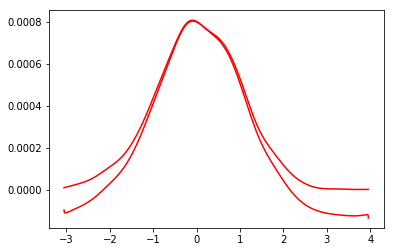

In [69]:
yyf_mode, yyf1_predicted = xgboost_algorithm(yyf2, yyf1)
yp_mode, yp1_predicted = xgboost_algorithm(yp_2, yp_1)

y = reconstruct_data(yyf1_predicted, yp_1)
plt.plot(X1, y, 'r')
plt.plot(X1, y1, 'r')
plt.show()